# Bayesian Model Mixing
### Evan Edwards

- Multivariate Mixing With The Following Models That Use Mixed-Informative Priors:
    - PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID)
    - PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID)
    - PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID)
    - PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID)

In [1]:
from Taweret.core.base_model import BaseModel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from Taweret.mix.gaussian import Multivariate
from math import sqrt
import arviz as az
import logging
import bambi as bmb
import pymc as pm
import scipy
import time

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
# Fixed random seed to ensure reproducibility and the possiblility for optimization
RANDOM_SEED = 9572404
rng = np.random.default_rng(RANDOM_SEED)


In [4]:
# Defining to disable output later for ease of visibility
logger = logging.getLogger("pymc")
# Disabling sampling messages
logger.setLevel(logging.ERROR)

In [5]:
# Load dataset
PISA2018 = pd.read_csv("pisa2018.BayesBook.csv")
# Data processing: converting categorical values to numerical values
PISA2018['Female'] = PISA2018['Female'].replace({'Female': 1.0, 'Male': 0.0})
# Converting numerical to categorical values
PISA2018['SchoolID'] = pd.Categorical(PISA2018['SchoolID']).codes

In [6]:
#PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID)
start_time = time.time()
model1 = bmb.Model("PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID)", PISA2018, categorical = ["SchoolID"])
priors = {"Intercept": bmb.Prior("Normal", mu=0, sigma=100),
          "Female": bmb.Prior("Normal", mu=0, sigma=10),
          "ESCS": bmb.Prior("Normal", mu=np.mean(PISA2018["ESCS"]), sigma=np.std(PISA2018["ESCS"])),
          "HOMEPOS": bmb.Prior("Normal", mu=np.mean(PISA2018["HOMEPOS"]), sigma=100),
          "ICTRES": bmb.Prior("Normal", mu=np.mean(PISA2018["ICTRES"]), sigma=np.std(PISA2018["ICTRES"])),
          "1|SchoolID": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=100)),
          "ICTRES|SchoolID": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=100)),
          "sigma": bmb.Prior("HalfNormal", sigma=10)}
model1.set_priors(priors = priors)

trace1 = model1.fit(draws=2000, random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

post_pred_model1 = model1.predict(trace1,data = PISA2018, inplace=False)
mean_pred_model1 = np.array(post_pred_model1.posterior["PV1READ_mean"].mean(dim=["chain", "draw"]))
print(f'The RMSE for model 1 - PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID) is: {sqrt(mean_squared_error(PISA2018["PV1READ"], mean_pred_model1))}')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Computation time: {elapsed_time} seconds")


The RMSE for model 1 - PV1READ ~ Female + ESCS + HOMEPOS + ICTRES + (1 + ICTRES | SchoolID) is: 94.1648602282953
Computation time: 177.44600987434387 seconds


Mean upper and lower bounds of the 95% CI: 95.67786641193362 - 117.06398223032717


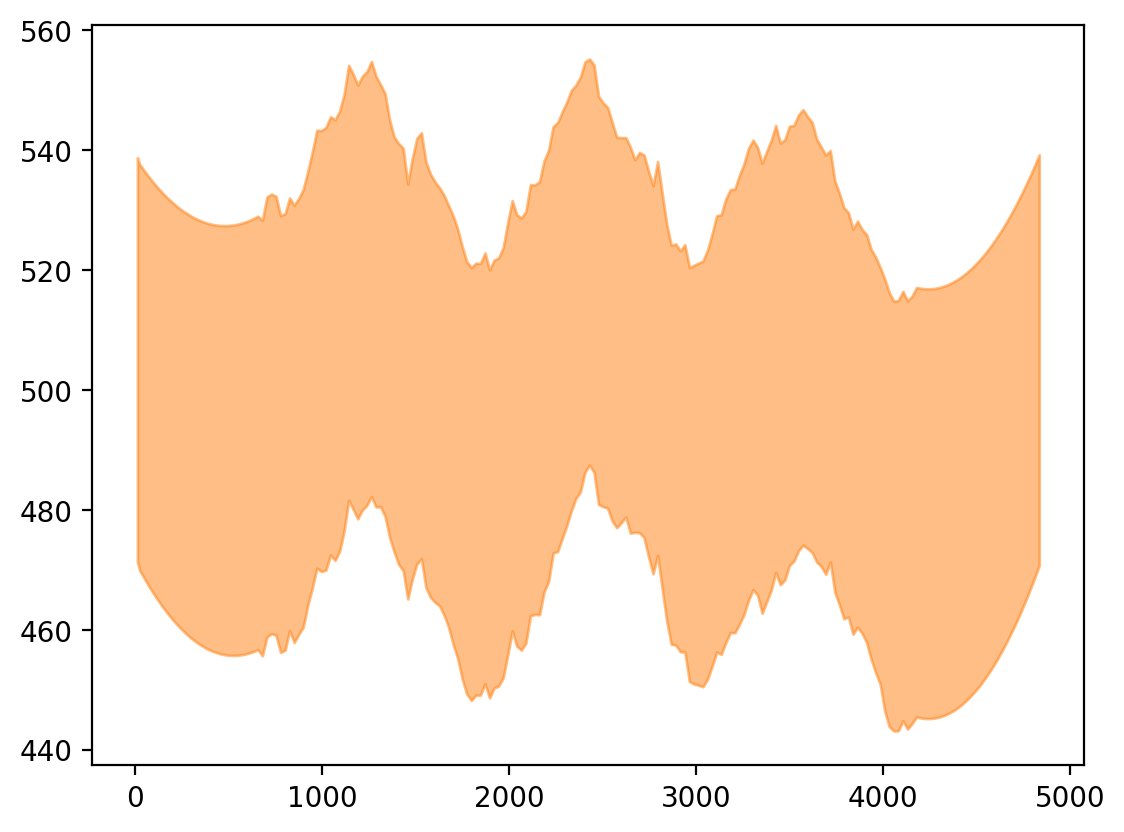

In [7]:
az.plot_hdi(range(0,len(PISA2018["PV1READ"])),post_pred_model1.posterior["PV1READ_mean"], hdi_prob=0.95)
plt.show
hdi = az.hdi(post_pred_model1, hdi_prob=0.95)
print(f"Mean upper and lower bounds of the 95% CI: {np.mean(np.array(hdi.to_array().sel(hdi='lower'))).astype(float)} - {np.mean(np.array(hdi.to_array().sel(hdi='higher'))).astype(float)}")

In [8]:
#PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID)
start_time = time.time()
model2 = bmb.Model("PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID)", PISA2018, categorical = ["SchoolID"])

priors = {"Intercept": bmb.Prior("Normal", mu=0, sigma=100),
          "JOYREAD": bmb.Prior("Normal", mu=np.mean(PISA2018["JOYREAD"]), sigma=np.std(PISA2018["JOYREAD"])),
          "PISADIFF": bmb.Prior("Normal", mu=0, sigma=100),
          "SCREADCOMP": bmb.Prior("Normal", mu=np.mean(PISA2018["SCREADCOMP"]), sigma=10),
          "SCREADDIFF": bmb.Prior("Normal", mu=np.mean(PISA2018["SCREADDIFF"]), sigma=np.std(PISA2018["SCREADDIFF"])),
          "1|SchoolID": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=100)),
          "sigma": bmb.Prior("HalfNormal", sigma=10)}
model2.set_priors()

trace2 = model2.fit(draws=2000, random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

post_pred_model2 = model2.predict(trace2, data = PISA2018, inplace=False)
mean_pred_model2 = np.array(post_pred_model2.posterior["PV1READ_mean"].mean(dim=["chain", "draw"]))
print(f'The RMSE for model 2 - PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID) is: {sqrt(mean_squared_error(PISA2018["PV1READ"], mean_pred_model2))}')

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Computation time: {elapsed_time} seconds")


The RMSE for model 2 - PV1READ ~ JOYREAD + PISADIFF + SCREADCOMP + SCREADDIFF + (1|SchoolID) is: 85.45787952431597
Computation time: 98.24102807044983 seconds


Mean upper and lower bounds of the 95% CI: 114.54119840737951 - 133.14658859739865


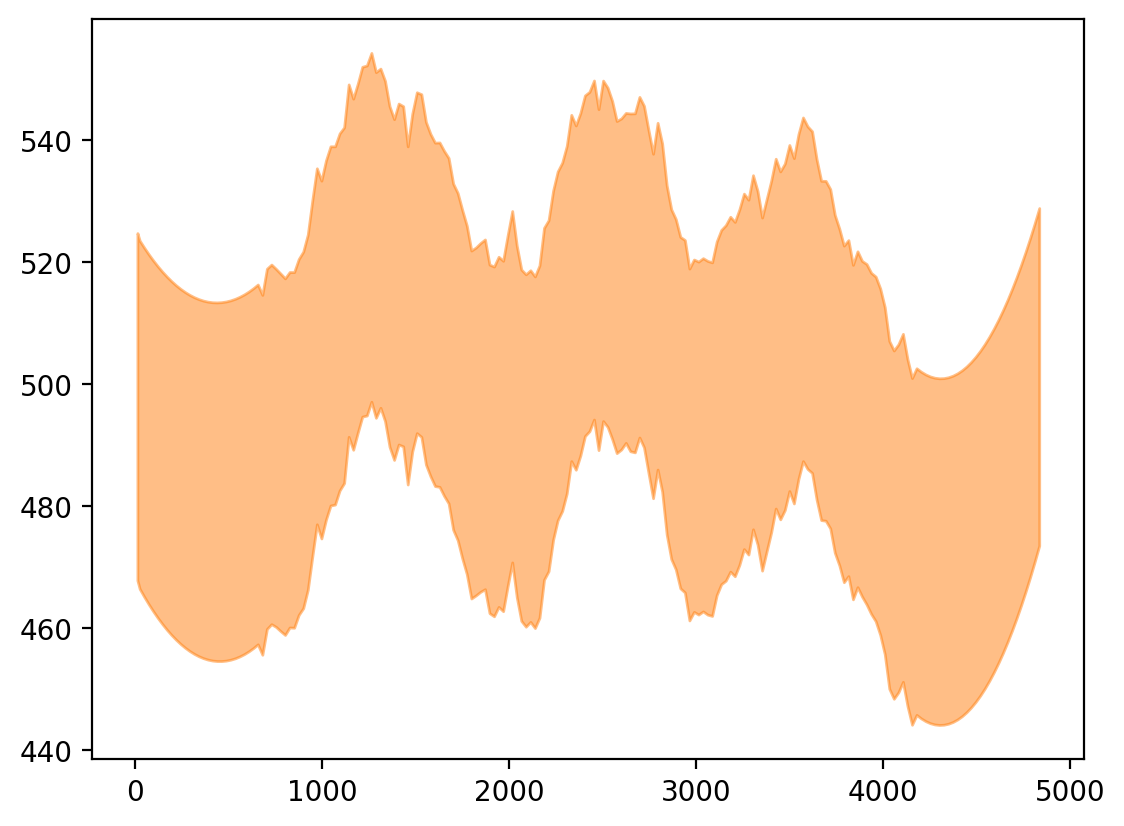

In [9]:
az.plot_hdi(range(0,len(PISA2018["PV1READ"])),post_pred_model2.posterior["PV1READ_mean"], hdi_prob=0.95)
plt.show
hdi = az.hdi(post_pred_model2, hdi_prob=0.95)
print(f"Mean upper and lower bounds of the 95% CI: {np.mean(np.array(hdi.to_array().sel(hdi='lower'))).astype(float)} - {np.mean(np.array(hdi.to_array().sel(hdi='higher'))).astype(float)}")

In [10]:
#PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID)
start_time = time.time()
model3 = bmb.Model("PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID)", PISA2018, categorical = ["SchoolID"])

priors = {"Intercept": bmb.Prior("Normal", mu=0, sigma=100),
          "METASUM": bmb.Prior("Normal", mu=np.mean(PISA2018["METASUM"]), sigma=np.std(PISA2018["METASUM"])),
          "GFOFAIL": bmb.Prior("Normal", mu=0, sigma=100),
          "MASTGOAL": bmb.Prior("Normal", mu=np.mean(PISA2018["MASTGOAL"]), sigma=10),
          "SWBP": bmb.Prior("Normal", mu=0, sigma=100),
          "WORKMAST": bmb.Prior("Normal", mu=np.mean(PISA2018["WORKMAST"]), sigma=10),
          "ADAPTIVITY": bmb.Prior("Normal", mu=np.mean(PISA2018["ADAPTIVITY"]), sigma=100),
          "COMPETE": bmb.Prior("Normal", mu=np.mean(PISA2018["COMPETE"]), sigma=np.std(PISA2018["COMPETE"])),
          "1|SchoolID": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=100)),
          "sigma": bmb.Prior("HalfNormal", sigma=10)}
model3.set_priors(priors = priors)

trace3 = model3.fit(draws=2000, random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True})

post_pred_model3 = model3.predict(trace3, data = PISA2018, inplace=False)
mean_pred_model3 = np.array(post_pred_model3.posterior["PV1READ_mean"].mean(dim=["chain", "draw"]))
print(f'The RMSE for model 3 - PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID) is: {sqrt(mean_squared_error(PISA2018["PV1READ"], mean_pred_model3))}')


end_time = time.time()
elapsed_time = end_time - start_time

print(f"Computation time: {elapsed_time} seconds")

The RMSE for model 3 - PV1READ ~ METASUM + GFOFAIL + MASTGOAL + SWBP + WORKMAST + ADAPTIVITY + COMPETE + (1|SchoolID) is: 91.30095525810611
Computation time: 206.16021728515625 seconds


Mean upper and lower bounds of the 95% CI: 89.6828639488815 - 105.20385893110081


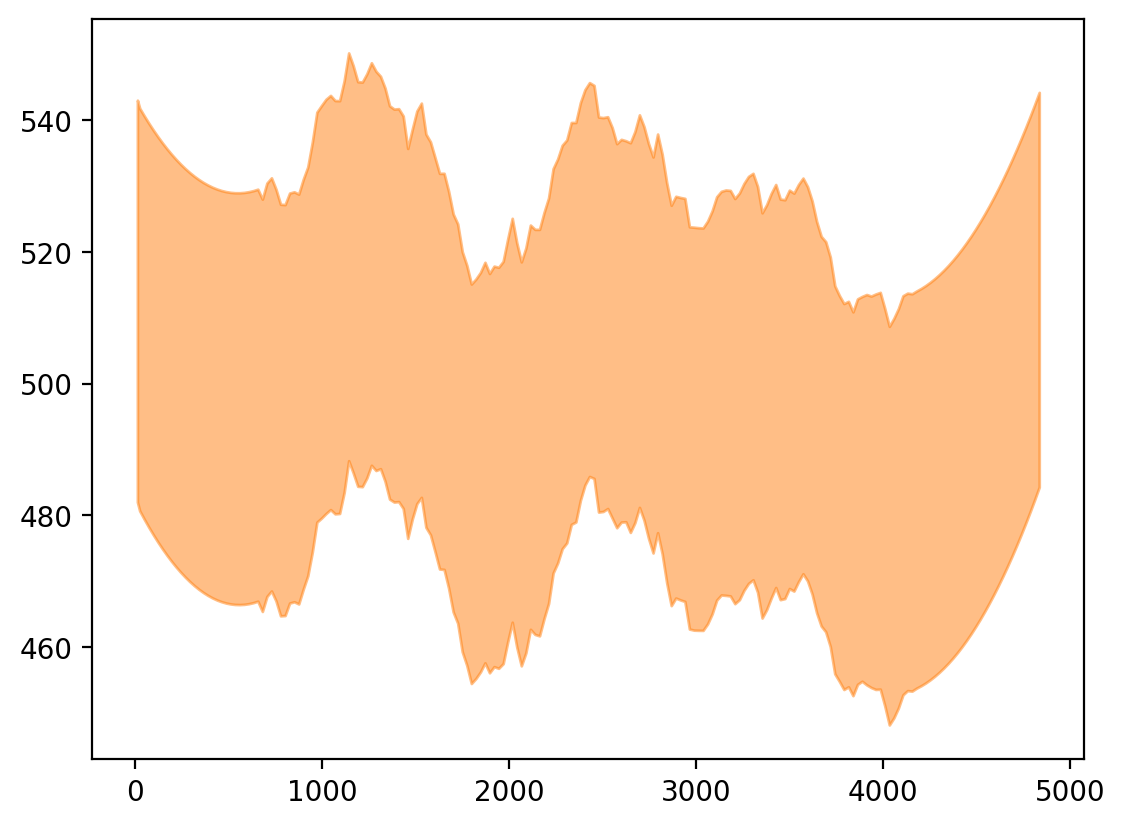

In [11]:
az.plot_hdi(range(0,len(PISA2018["PV1READ"])),post_pred_model3.posterior["PV1READ_mean"], hdi_prob=0.95)
plt.show
hdi = az.hdi(post_pred_model3, hdi_prob=0.95)
print(f"Mean upper and lower bounds of the 95% CI: {np.mean(np.array(hdi.to_array().sel(hdi='lower'))).astype(float)} - {np.mean(np.array(hdi.to_array().sel(hdi='higher'))).astype(float)}")

In [12]:
#PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID)
start_time = time.time()
model4 = bmb.Model("PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID)", PISA2018, categorical = ["SchoolID"])

priors = {"Intercept": bmb.Prior("Normal", mu=0, sigma=100),
          "PERFEED": bmb.Prior("Normal", mu=np.mean(PISA2018["PERFEED"]), sigma=np.std(PISA2018["PERFEED"])),
          "TEACHINT": bmb.Prior("Normal", mu=np.mean(PISA2018["TEACHINT"]), sigma=np.std(PISA2018["TEACHINT"])),
          "BELONG": bmb.Prior("Normal", mu=np.mean(PISA2018["BELONG"]), sigma=100),
          "1|SchoolID": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=100)),
          "TEACHINT|SchoolID": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=100)),
          "sigma": bmb.Prior("HalfNormal", sigma=10)}
model4.set_priors(priors = priors)

trace4 = model4.fit(draws=2000, random_seed=RANDOM_SEED,idata_kwargs={'log_likelihood':True} ) 

post_pred_model4 = model4.predict(trace4, data = PISA2018, inplace=False)
mean_pred_model4 = np.array(post_pred_model4.posterior["PV1READ_mean"].mean(dim=["chain", "draw"]))
print(f'The RMSE for model 4 - PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID) is: {sqrt(mean_squared_error(PISA2018["PV1READ"], mean_pred_model4))}')


end_time = time.time()
elapsed_time = end_time - start_time

print(f"Computation time: {elapsed_time} seconds")

The RMSE for model 4 - PV1READ ~ PERFEED + TEACHINT + BELONG + (1 + TEACHINT | SchoolID) is: 94.72730464194656
Computation time: 157.57471442222595 seconds
CPU times: total: 40.3 s
Wall time: 2min 37s


Mean upper and lower bounds of the 95% CI: 103.8855657913471 - 129.38984730300865


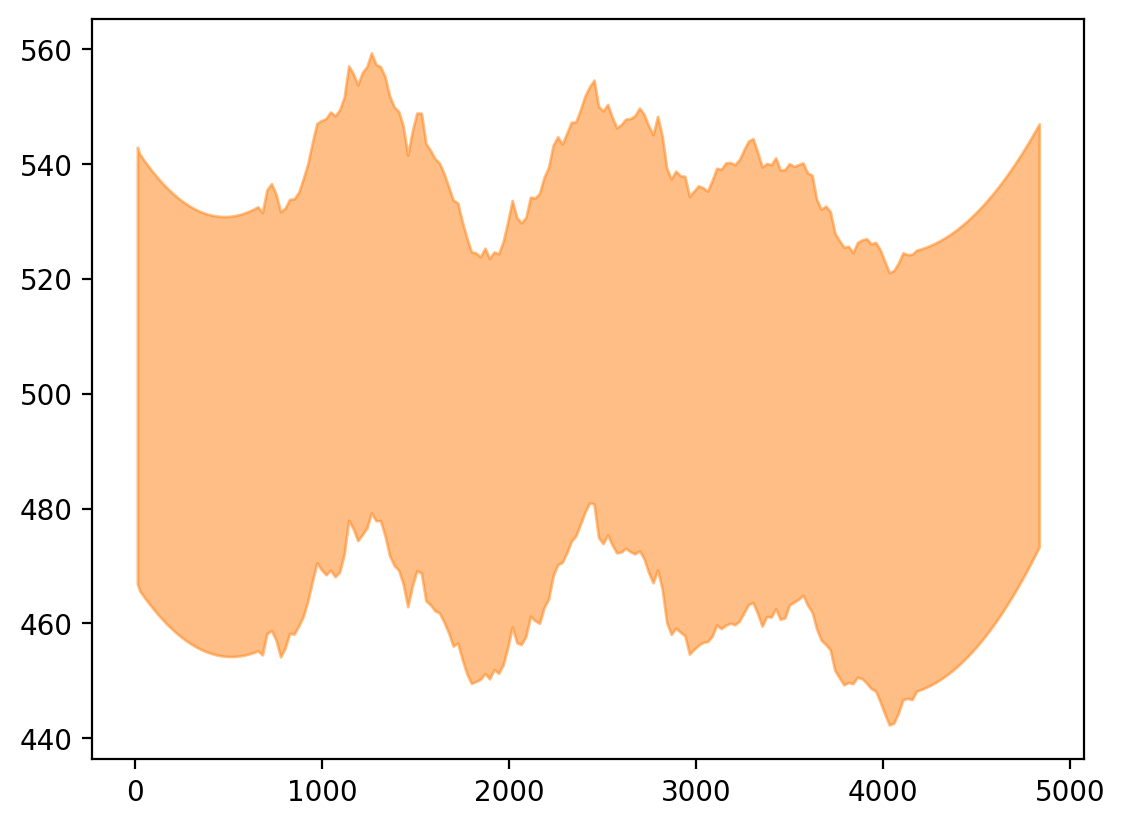

In [13]:
az.plot_hdi(range(0,len(PISA2018["PV1READ"])),post_pred_model4.posterior["PV1READ_mean"], hdi_prob=0.95)
plt.show
hdi = az.hdi(post_pred_model4, hdi_prob=0.95)
print(f"Mean upper and lower bounds of the 95% CI: {np.mean(np.array(hdi.to_array().sel(hdi='lower'))).astype(float)} - {np.mean(np.array(hdi.to_array().sel(hdi='higher'))).astype(float)}")

In [16]:
#bma
traces = [post_pred_model1, post_pred_model2, post_pred_model3, post_pred_model4]

model_dict = dict(zip(["model_1", "model_2", "model_3", "model_4"], traces))
comp = az.compare(model_dict, method = "BB-pseudo-BMA")
for x in range(0,len(traces)):
    traces[x] = az.InferenceData(**{"posterior_predictive": traces[x].posterior,"observed_data": traces[x].observed_data})

ppc_w = az.stats.weight_predictions(
    idatas=traces,
    weights=comp.weight.sort_index(ascending=True)
)


mean = ppc_w.posterior_predictive["PV1READ_mean"].mean(dim=["sample"])
print(f'The RMSE for BMA is: {sqrt(mean_squared_error(PISA2018["PV1READ"], mean))}')


The RMSE for BMA is: 85.45787952431597


In [46]:
# A wrapper class for the Bambi/PYMC models to be compatible with the Taweret framework
class BMBWrapper(BaseModel):
    def __init__(self, model, idata, posterior_predictive):
        self.model = model
        self.idata = idata
        self.posterior_predictive = posterior_predictive
        
    def evaluate(self, model_parameters):
        post_pred = self.model.predict(self.idata, data = model_parameters, inplace=False).posterior[self.posterior_predictive]
        return np.array(post_pred.mean(dim=["chain", "draw"])).reshape(-1, 1), np.sqrt(np.array(post_pred.var(dim=["chain", "draw"]))).flatten().reshape(-1, 1)

    
    def log_likelihood_elementwise(self,x_exp, y_exp, y_err, model_params):
        y = self.evaluate(model_params)[0]
        
        return np.exp(-(y - y_exp) **2 / (2 * y_err ** 2)) \
            / np.sqrt(2 * np.pi * y_err ** 2)
    
    def set_prior(self, prior_dict):
        self.model.set_priors(self, priors=prior_dict)


In [47]:
# Using the multivariate mixer to combine the four models in a gaussian form

# Defining a dictionary of the models
models = {
            "1": BMBWrapper(model1, trace1, "PV1READ_mean"),
            "2": BMBWrapper(model2, trace2, "PV1READ_mean"),
            "3": BMBWrapper(model3, trace3, "PV1READ_mean"),
            "4": BMBWrapper(model4, trace4, "PV1READ_mean")
}

# The multivariate model
multivariate_mixer = Multivariate(PISA2018, models)

# Gather predictions and calculate the RMSE score
draws, mean, intervals, std_dev = multivariate_mixer.predict(ci=95)

print(f'The RMSE score of the mixer: {((sqrt(mean_squared_error(PISA2018["PV1READ"], mean))))}')

The RMSE score of the mixer: 87.61163854218172
